<a href="https://colab.research.google.com/github/hariganesht/hariganesht.github.io/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Download Lichess chess database
!wget https://database.lichess.org/standard/lichess_db_standard_rated_2016-02.pgn.zst -P /content/

--2025-11-10 02:45:52--  https://database.lichess.org/standard/lichess_db_standard_rated_2016-02.pgn.zst
Resolving database.lichess.org (database.lichess.org)... 51.178.209.54, 2001:41d0:426:3600::
Connecting to database.lichess.org (database.lichess.org)|51.178.209.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 908213555 (866M) [application/octet-stream]
Saving to: ‘/content/lichess_db_standard_rated_2016-02.pgn.zst’

lichess_db_standard 100%[===================>] 866.14M  29.2MB/s    in 40s     

2025-11-10 02:46:33 (21.6 MB/s) - ‘/content/lichess_db_standard_rated_2016-02.pgn.zst’ saved [908213555/908213555]



In [4]:
# install Stockfish chess engine
!pip install python-chess zstandard pandas matplotlib numpy scipy tqdm moviepy
!pip install pybullet
!pip install stockfish

  Using cached python_chess-1.999-py3-none-any.whl.metadata (776 bytes)
  Using cached chess-1.11.2.tar.gz (6.1 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=46307ab48e8b3179d99b0a1a30356f66cb901cc804d23750e9ea229a4fda406e
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.7-cp312-cp312-linux_x86_64.whl size=99873464 sha256=12d58e7b7b71fd15a23b4ad704116e928016f1fe6503738955d5e2ca647c81f2
  Stored in directory: /root/.cache/pip/wheels/72/95/1d/b336e5ee612ae9a019bfff4dc0bedd100ee6f0570db205fdf8
Successfully built pybullet
  Using cached stockfish-3.28.0-py3-none-any.whl.metadata (12 kB)
Using cached stockfish-3.28.0-py3-none-any.whl (13 kB)


In [5]:
!sudo apt-get update -y
!sudo apt-get install -y stockfish

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 384 kB in 2s (220 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem 

Loaded rows: 1000
Evaluating 1000 positions with Stockfish (depth=8)...


100%|██████████| 1000/1000 [04:12<00:00,  3.95it/s]



Chess signatures: {'acpl_mean': 64.998, 'frac_subopt': 0.327, 'loss_aversion_ratio': 0.6056338028146303, 'n': 1000}
Mapped PD params: {'baseline_coop': 0.11139999999999994, 'irr_noise': 0.3443, 'loss_bias': 0.7633802816887783}
Running λ=0.0 ...
Running λ=0.25 ...
Running λ=0.5 ...
Running λ=1.0 ...
Running λ=2.0 ...


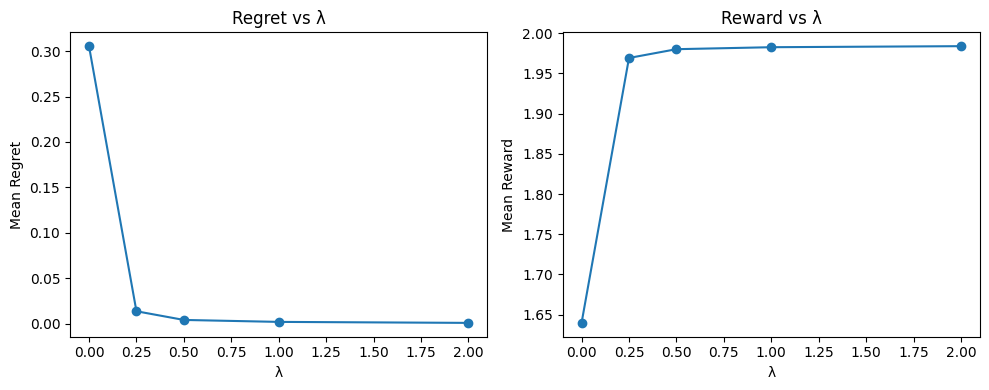


--- Summary ---
Signatures: {'acpl_mean': 64.998, 'frac_subopt': 0.327, 'loss_aversion_ratio': 0.6056338028146303, 'n': 1000}
Mapped PD params: {'baseline_coop': 0.11139999999999994, 'irr_noise': 0.3443, 'loss_bias': 0.7633802816887783}
Best λ (min avg regret): 2.0


In [6]:
import os, math, random, json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import wilcoxon
import statistics
import chess, chess.pgn
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from stockfish import Stockfish
import zstandard as zstd

# creates a configuration

CONFIG = {
    "ZST_PATH": "/content/lichess_db_standard_rated_2016-02.pgn.zst",
    "SAMPLE_LIMIT": 1000,
    "STOCKFISH_PATH": "/usr/games/stockfish",
    "STOCKFISH_DEPTH": 8,
    "LAMBDA_LIST": [0.0, 0.25, 0.5, 1.0, 2.0],
    "SEEDS_PER_LAMBDA": 12,
    "PD_ROUNDS": 50,
    "EPISODES_PER_SEED": 200,
    "LR": 0.5,
    "RNG_SEED": 42,
    "BOOTSTRAP_SAMPLES": 2000,
}
random.seed(CONFIG["RNG_SEED"])
np.random.seed(CONFIG["RNG_SEED"])

# Defines what a pgn is, converts zst to pgn, and extracts move pairs as fen

def load_pgn_zst_fen_moves(path, limit=2000):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    recs = []
    dctx = zstd.ZstdDecompressor()
    with open(path, 'rb') as fh:
        with dctx.stream_reader(fh) as reader:
            import io
            txt = io.TextIOWrapper(reader, encoding='utf-8', errors='ignore')
            parsed = 0
            while parsed < limit:
                game = chess.pgn.read_game(txt)
                if game is None:
                    break
                board = game.board()
                for mv in game.mainline_moves():
                    recs.append({"fen": board.fen(), "move_uci": mv.uci()})
                    board.push(mv)
                    parsed += 1
                    if parsed >= limit:
                        break
    return recs

# apply a new move to the fen, and load the new fen

def apply_move_to_fen(fen, move_uci):
    b = chess.Board(fen)
    b.push_uci(move_uci)
    return b.fen()

# evaluating the irrationality of a move

def eval_position_single(r, stockfish_path, depth):
    try:
        sf = Stockfish(path=stockfish_path, depth=depth)
        sf.update_engine_parameters({"Threads": 1, "Hash": 64})
        fen, mv = r['fen'], r['move_uci']

        # defining a best move according to stockfish

        sf.set_fen_position(fen)
        best = sf.get_best_move()
        if best is None:
            return None
        sf.set_fen_position(fen)
        eval_before = sf.get_evaluation()
        if eval_before['type'] == 'cp':
            eval_before_val = eval_before['value']
        else:
            eval_before_val = 100000.0 if eval_before['value'] > 0 else -100000.0

        sf.set_fen_position(apply_move_to_fen(fen, best))
        eval_best = sf.get_evaluation()
        eval_best_val = eval_best['value'] if eval_best['type'] == 'cp' else 0

        sf.set_fen_position(apply_move_to_fen(fen, mv))
        eval_h = sf.get_evaluation()
        eval_h_val = eval_h['value'] if eval_h['type'] == 'cp' else 0

        # calculating acpl for each move

        acpl_val = max(0.0, eval_best_val - eval_h_val)
        return eval_before_val, acpl_val
    except Exception:
        return None

def analyze_chess_irrationality(rows, stockfish_path, depth):
    print(f"Evaluating {len(rows)} positions with Stockfish (depth={depth})...")
    acpls, win_moves, lose_moves, win_subopt, lose_subopt = [], 0, 0, 0, 0
    with ProcessPoolExecutor(max_workers=4) as ex:
        results = list(tqdm(ex.map(eval_position_single,
                                   rows,
                                   [stockfish_path]*len(rows),
                                   [depth]*len(rows)),
                            total=len(rows)))

# define suboptimality fraction

    for res in results:
        if res is None:
            continue
        eval_before, acpl_val = res
        acpls.append(acpl_val)
        if eval_before >= 0:
            win_moves += 1
            if acpl_val > 0:
                win_subopt += 1
        else:
            lose_moves += 1
            if acpl_val > 0:
                lose_subopt += 1
    acpl_mean = float(np.mean(acpls)) if acpls else 0.0
    frac_subopt = float(sum(1 for x in acpls if x > 0) / len(acpls)) if acpls else 0.0
    loss_aversion_ratio = (
        (lose_subopt / (lose_moves + 1e-9)) /
        (win_subopt / (win_moves + 1e-9))
        if win_moves > 0 else np.nan
    )

    # calculate all metrics

    return {
        "acpl_mean": acpl_mean,
        "frac_subopt": frac_subopt,
        "loss_aversion_ratio": loss_aversion_ratio,
        "n": len(acpls)
    }

# converting to prisoner's dilemma

def map_irrationality_to_PD_params(sig):
    frac = sig.get("frac_subopt", 0.1)
    lar = sig.get("loss_aversion_ratio", 1.0)
    baseline_coop = float(max(0.05, min(0.95, 0.7 - frac * 1.8)))
    irr_noise = float(min(0.6, 0.05 + frac * 0.9))
    loss_bias = float(min(2.0, max(0.2, 1.0 + (lar - 1.0) * 0.6)))
    return {"baseline_coop": baseline_coop, "irr_noise": irr_noise, "loss_bias": loss_bias}

# defining the prisoner's dilemma payoff matrix

PAYOFF = {('C', 'C'): (3, 3), ('C', 'D'): (0, 5), ('D', 'C'): (5, 0), ('D', 'D'): (1, 1)}

class PDPartner:
    def __init__(self, params):
        self.base = params['baseline_coop']
        self.noise = params['irr_noise']
        self.loss_bias = params['loss_bias']
        self.last_diff = 0.0
    def act(self):
        p = self.base
        if self.last_diff < 0:
            p *= (1.0 - (self.loss_bias - 1.0) * 0.5)
        p = p * (1.0 - self.noise) + self.noise * random.random()
        return 'C' if random.random() < p else 'D'
    def update(self, robot_reward, partner_reward):
        self.last_diff = partner_reward - robot_reward

class RegretRobot:
    def __init__(self, lambda_reg=0.0, lr=0.5):
        self.theta = 0.0
        self.lr = lr
        self.lambda_reg = lambda_reg
    def get_probs(self):
        expC = math.exp(self.theta)
        pC = expC / (expC + 1.0)
        return {"C": pC, "D": 1 - pC}
    def act(self):
        p = self.get_probs()
        return 'C' if random.random() < p['C'] else 'D'
    def get_expected_values(self, partner_p):
        evC = partner_p * 3 + (1 - partner_p) * 0
        evD = partner_p * 5 + (1 - partner_p) * 1
        return {"C": evC, "D": evD}
    def update(self, chosen, reward, expected_vals, regret):
        pC = self.get_probs()['C']
        I = 1.0 if chosen == 'C' else 0.0
        baseline = expected_vals[chosen]
        adv = reward - baseline
        signal = adv - self.lambda_reg * regret
        grad = (I - pC) * signal
        self.theta += self.lr * grad

def run_pd_experiment(pd_params, lambdas, seeds, episodes, rounds_per_ep, lr):
    all_results = []
    for lam in lambdas:
        per_seed_regs, per_seed_rewards = [], []
        print(f"Running λ={lam} ...")
        for s in range(seeds):
            random.seed(s + 1000)
            np.random.seed(s + 1000)
            robot = RegretRobot(lambda_reg=lam, lr=lr)
            seed_regrets, seed_rewards = [], []
            for ep in range(episodes):
                partner = PDPartner(pd_params)
                total_reg, total_rew = 0.0, 0.0
                for t in range(rounds_per_ep):
                    chosen = robot.act()
                    partner_act = partner.act()
                    r_robot, r_part = PAYOFF[(chosen, partner_act)]
                    expected = robot.get_expected_values(partner.base)
                    best_ev = max(expected.values())
                    inst_regret = best_ev - expected[chosen]
                    robot.update(chosen, r_robot, expected, inst_regret)
                    partner.update(r_robot, r_part)
                    total_reg += inst_regret
                    total_rew += r_robot
                seed_regrets.append(total_reg / rounds_per_ep)
                seed_rewards.append(total_rew / rounds_per_ep)
            per_seed_regs.append(np.mean(seed_regrets))
            per_seed_rewards.append(np.mean(seed_rewards))
        all_results.append({
            "lambda_reg": lam,
            "seed_regs": per_seed_regs,
            "seed_rews": per_seed_rewards,
            "mean_reg": np.mean(per_seed_regs),
            "mean_rew": np.mean(per_seed_rewards)
        })
    return all_results

def bootstrap_ci(data, func=np.mean, n_boot=2000, alpha=0.05):
    arr = np.array(data)
    n = len(arr)
    boots = [func(np.random.choice(arr, size=n, replace=True)) for _ in range(n_boot)]
    lo = np.percentile(boots, 100 * alpha / 2)
    hi = np.percentile(boots, 100 * (1 - alpha / 2))
    return lo, hi

def main():
    rows = load_pgn_zst_fen_moves(CONFIG['ZST_PATH'], limit=CONFIG['SAMPLE_LIMIT'])
    print(f"Loaded rows: {len(rows)}")

    sig = analyze_chess_irrationality(rows, CONFIG['STOCKFISH_PATH'], CONFIG['STOCKFISH_DEPTH'])
    print("\nChess signatures:", sig)

    pd_params = map_irrationality_to_PD_params(sig)
    print("Mapped PD params:", pd_params)

    results = run_pd_experiment(pd_params, CONFIG['LAMBDA_LIST'], CONFIG['SEEDS_PER_LAMBDA'],
                                CONFIG['EPISODES_PER_SEED'], CONFIG['PD_ROUNDS'], CONFIG['LR'])
    summary = []
    for r in results:
        lam = r['lambda_reg']
        regs, rews = r['seed_regs'], r['seed_rews']
        lo_reg, hi_reg = bootstrap_ci(regs)
        lo_rew, hi_rew = bootstrap_ci(rews)
        summary.append({
            "lambda_reg": lam, "mean_reg": np.mean(regs),
            "ci_reg": [lo_reg, hi_reg], "mean_rew": np.mean(rews),
            "ci_rew": [lo_rew, hi_rew]
        })

    lam_vals = [s['lambda_reg'] for s in summary]
    means_reg = [s['mean_reg'] for s in summary]
    means_rew = [s['mean_rew'] for s in summary]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(lam_vals, means_reg, '-o')
    plt.xlabel("λ"); plt.ylabel("Mean Regret"); plt.title("Regret vs λ")
    plt.subplot(1, 2, 2)
    plt.plot(lam_vals, means_rew, '-o')
    plt.xlabel("λ"); plt.ylabel("Mean Reward"); plt.title("Reward vs λ")
    plt.tight_layout(); plt.savefig("pd_tradeoff.png", dpi=200); plt.show()

if __name__ == "__main__":
    main()

Guided human p(straight) from chess = 0.423


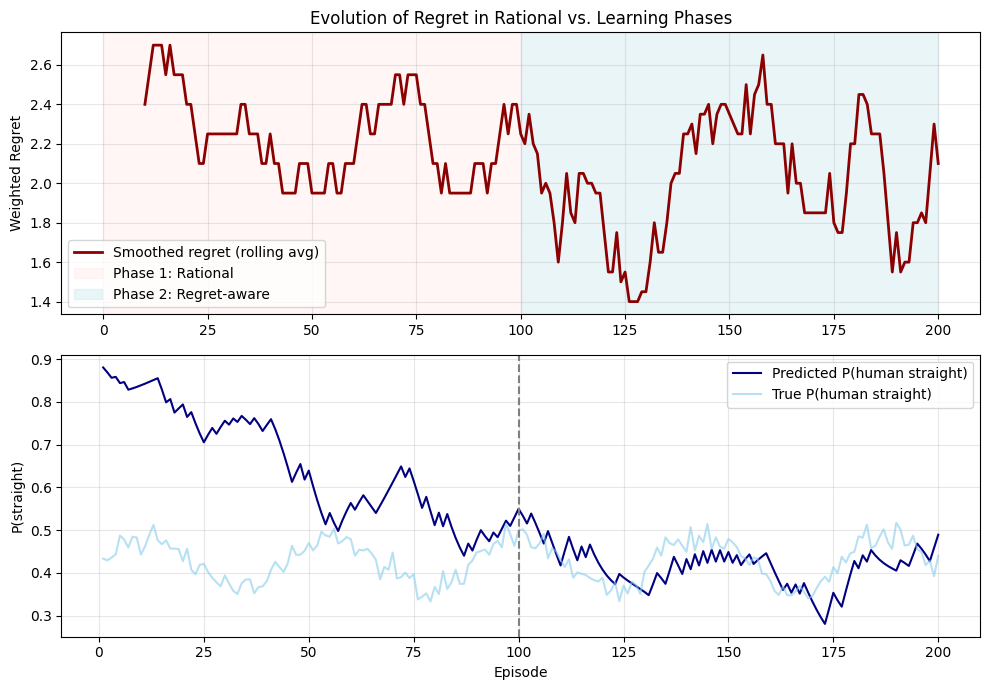


Summary:
Phase 1 avg regret = 2.235
Phase 2 avg regret = 1.990
Regret reduction = 10.96%
Action counts (Phase 1 Robot): Counter({'straight': 100})
Action counts (Phase 2 Robot): Counter({np.str_('swerve'): 66, np.str_('straight'): 34})
Action counts (Human): Counter({'swerve': 113, 'straight': 87})


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(42)

chess_stats = {
    "acpl_mean": 65.7122,              # deviation from optimal play (centipawn loss)
    "frac_subopt": 0.3174,             # fraction of suboptimal moves
    "loss_aversion_ratio": 0.775     # risk aversion from human play
}

# Convert chess irrationality signature > probability of risky human action

def chess_to_human_p(ch_stats):
    frac = ch_stats.get("frac_subopt", 0.3)
    acpl = ch_stats.get("acpl_mean", 50.0) / 100.0
    lav = ch_stats.get("loss_aversion_ratio", 0.9)
    score = 0.6 * frac + 0.25 * acpl + 0.15 * (1.0 - lav)
    k = 8.0
    p = 0.12 + 0.8 * (1.0 / (1.0 + np.exp(-k * (score - 0.45))))
    return float(np.clip(p, 0.02, 0.98))

p_human_straight_base = chess_to_human_p(chess_stats)
print("Guided human p(straight) from chess =", round(p_human_straight_base, 3))

TOTAL_EPISODES = 200
PHASE_SPLIT = 100  # robot observes first 100, learns in next 100
ROBOT_LAMBDA = 1.2
PRED_LR = 0.12
TAU = 0.2
WEIGHT_SELF = 0.7
WEIGHT_HUMAN = 0.3

# Payoff matrix: (robot harm, human harm)

PAYOFFS = {
    ("straight", "straight"): (-3.0, -3.0),
    ("swerve", "swerve"):     (-1.0, -1.0),
    ("straight", "swerve"):   (0.0, -5.0),
    ("swerve", "straight"):   (-5.0, 0.0),
}
ACTIONS = ["straight", "swerve"]

# defining human irrationality

def human_draw_guided(t, base_p=p_human_straight_base):
    fluct = 0.06 * np.sin(t / 7.0)  # mild irrational fluctuation
    p = np.clip(base_p + fluct + np.random.randn() * 0.02, 0.01, 0.99)
    return "straight" if np.random.rand() < p else "swerve", p

# logistic regression

class OnlinePredictor:
    def __init__(self, lr=PRED_LR):
        self.w = np.zeros(2)
        self.lr = lr
        self.w[0] = 2.0  # assume rational human initially
    def features(self, t):
        return np.array([1.0, np.sin(t / 10.0)])
    def predict(self, t):
        x = self.features(t)
        z = np.dot(self.w, x)
        return 1.0 / (1.0 + np.exp(-z))
    def update(self, t, y):
        x = self.features(t)
        p = self.predict(t)
        grad = (y - p) * x
        self.w += self.lr * grad  # online logistic update

# rl algorithm

def expected_regret(pred_ph):
    exp = {}
    ph = pred_ph
    for a in ACTIONS:
        r_harm = ph * (-PAYOFFS[(a, "straight")][0]) + (1 - ph) * (-PAYOFFS[(a, "swerve")][0])
        h_harm = ph * (-PAYOFFS[(a, "straight")][1]) + (1 - ph) * (-PAYOFFS[(a, "swerve")][1])
        exp[a] = WEIGHT_SELF * r_harm + WEIGHT_HUMAN * h_harm
    return exp

# changing policy

def robot_choose_action(pred_ph, lam=ROBOT_LAMBDA, tau=TAU):
    exp_r = expected_regret(pred_ph)
    utils = np.array([-exp_r[a] for a in ACTIONS])
    logits = lam * utils / tau
    logits -= logits.max()
    probs = np.exp(logits)
    probs /= probs.sum()
    act = np.random.choice(ACTIONS, p=probs)
    return act, probs, exp_r

predictor = OnlinePredictor(lr=PRED_LR)
robot_regret, predicted_probs, true_probs = [], [], []
robot_actions, human_actions = [], []

for t in range(TOTAL_EPISODES):
    human_move, true_p = human_draw_guided(t)
    pred_ph = predictor.predict(t)

    if t < PHASE_SPLIT:
        robot_act = "straight"  # rational baseline (dominant strategy)
    else:
        robot_act, probs, exp_r = robot_choose_action(pred_ph, lam=ROBOT_LAMBDA, tau=TAU)

    r_h, h_h = PAYOFFS[(robot_act, human_move)]
    regret = WEIGHT_SELF * (-r_h) + WEIGHT_HUMAN * (-h_h)

    y = 1 if human_move == "straight" else 0
    predictor.update(t, y)

    robot_regret.append(regret)
    predicted_probs.append(pred_ph)
    true_probs.append(true_p)
    robot_actions.append(robot_act)
    human_actions.append(human_move)

episodes = np.arange(1, TOTAL_EPISODES + 1)
smooth_regret = np.convolve(robot_regret, np.ones(10) / 10, mode='valid')

plt.figure(figsize=(10, 7))

# (1) Regret curve
plt.subplot(2, 1, 1)
plt.plot(episodes[9:], smooth_regret, color='darkred', lw=2, label='Smoothed regret (rolling avg)')
plt.axvspan(0, PHASE_SPLIT, color='mistyrose', alpha=0.3, label='Phase 1: Rational')
plt.axvspan(PHASE_SPLIT, TOTAL_EPISODES, color='lightblue', alpha=0.25, label='Phase 2: Regret-aware')
plt.ylabel("Weighted Regret")
plt.title("Evolution of Regret in Rational vs. Learning Phases")
plt.legend(); plt.grid(True, alpha=0.3)

# (2) Human irrationality estimate
plt.subplot(2, 1, 2)
plt.plot(episodes, predicted_probs, label='Predicted P(human straight)', color='navy')
plt.plot(episodes, true_probs, label='True P(human straight)', alpha=0.6, color='skyblue')
plt.axvline(PHASE_SPLIT, color='gray', linestyle='--')
plt.ylabel("P(straight)"); plt.xlabel("Episode")
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("regret_learning_ai.png", dpi=400, bbox_inches='tight', transparent=True)
plt.savefig("regret_learning_ai.pdf", bbox_inches='tight', transparent=True)
plt.show()

phase1_reg = np.mean(robot_regret[:PHASE_SPLIT])
phase2_reg = np.mean(robot_regret[PHASE_SPLIT:])
improvement = 100 * (phase1_reg - phase2_reg) / phase1_reg

print("\nSummary:")
print(f"Phase 1 avg regret = {phase1_reg:.3f}")
print(f"Phase 2 avg regret = {phase2_reg:.3f}")
print(f"Regret reduction = {improvement:.2f}%")
print("Action counts (Phase 1 Robot):", Counter(robot_actions[:PHASE_SPLIT]))
print("Action counts (Phase 2 Robot):", Counter(robot_actions[PHASE_SPLIT:]))
print("Action counts (Human):", Counter(human_actions))